# Classifying Images with Transfer Learning

## Introduction
In this notebook, you learn how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding.You load a pre-trained model which is trained on very large, general-purpose datasets and transfer that knowledge to the actual dataset that you want to classify. This means you use a pre-trained model instead of the Flattened layer as your first layer.

## Learning objectives

* Understand how to set up preprocessing in order to _convert image type and resize the image to the desired size._

* Understand how to implement transfer learning with MobileNet.

Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_with_transfer_learning.ipynb)

In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2.6.5


## Defining Helper Functions


In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);
    ax[flower].axis('off')

In [3]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # TODO 1: Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Transfer Learning with MobileNet

Pre-trained models are models that are trained on large datasets and made available to be used as a way to create embeddings. For example, the [MobileNet model](https://ai.googleblog.com/2017/06/mobilenets-open-source-models-for.html) is a model with 1-4 million parameters that was trained on the [ImageNet (ILSVRC) dataset](http://www.image-net.org/challenges/LSVRC/) which consists of millions of images corresponding to hundreds of categories that were scraped from the web. The resulting embedding therefore has the ability to efficiently compress the information found in a wide variety of images. As long as the images you want to classify are similar in nature to the ones that MobileNet was trained on, the embeddings from MobileNet should give a great pre-trained embedding that you can use as a starting point to train a model on your smaller tf-flowers (5 flowers) dataset.
A pre-trained MobileNet is available on TensorFlow Hub and you can easily load it as a Keras layer by passing in the URL to the trained model.

In [4]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  # TODO 2: Group a linear stack of layers into a tf.keras.Model
  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
  training_plot(['loss', 'accuracy'], history)
  return model

2024-07-18 23:13:48.331796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-07-18 23:13:48.331839: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-18 23:13:48.331869: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240718-170734): /proc/driver/nvidia/version does not exist
2024-07-18 23:13:48.335387: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


2024-07-18 23:13:51.066612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


104/104 [==============================] - 116s 1s/step - loss: 0.6979 - accuracy: 0.7491 - val_loss: 0.3903 - val_accuracy: 0.8676
Epoch 2/5
104/104 [==============================] - 109s 1s/step - loss: 0.3083 - accuracy: 0.9009 - val_loss: 0.3434 - val_accuracy: 0.8973
Epoch 3/5
104/104 [==============================] - 108s 1s/step - loss: 0.2186 - accuracy: 0.9321 - val_loss: 0.3310 - val_accuracy: 0.8919
Epoch 4/5
104/104 [==============================] - 109s 1s/step - loss: 0.1647 - accuracy: 0.9539 - val_loss: 0.3338 - val_accuracy: 0.8946
Epoch 5/5
104/104 [==============================] - 106s 1s/step - loss: 0.1283 - accuracy: 0.9688 - val_loss: 0.3440 - val_accuracy: 0.8892


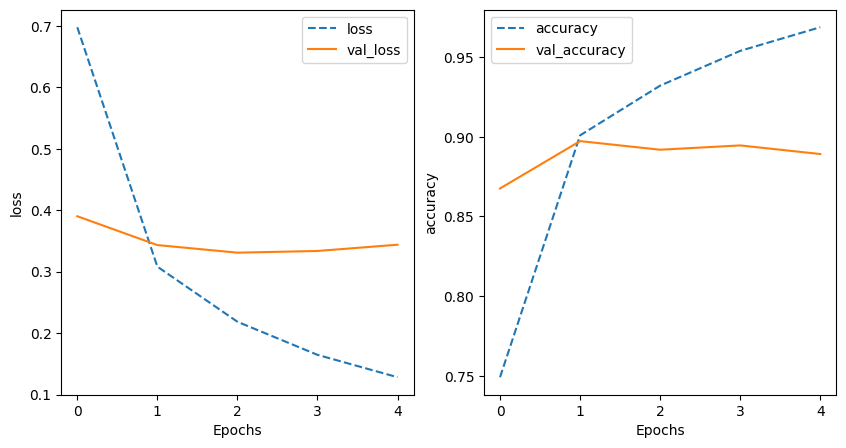

In [5]:
model = train_and_evaluate()

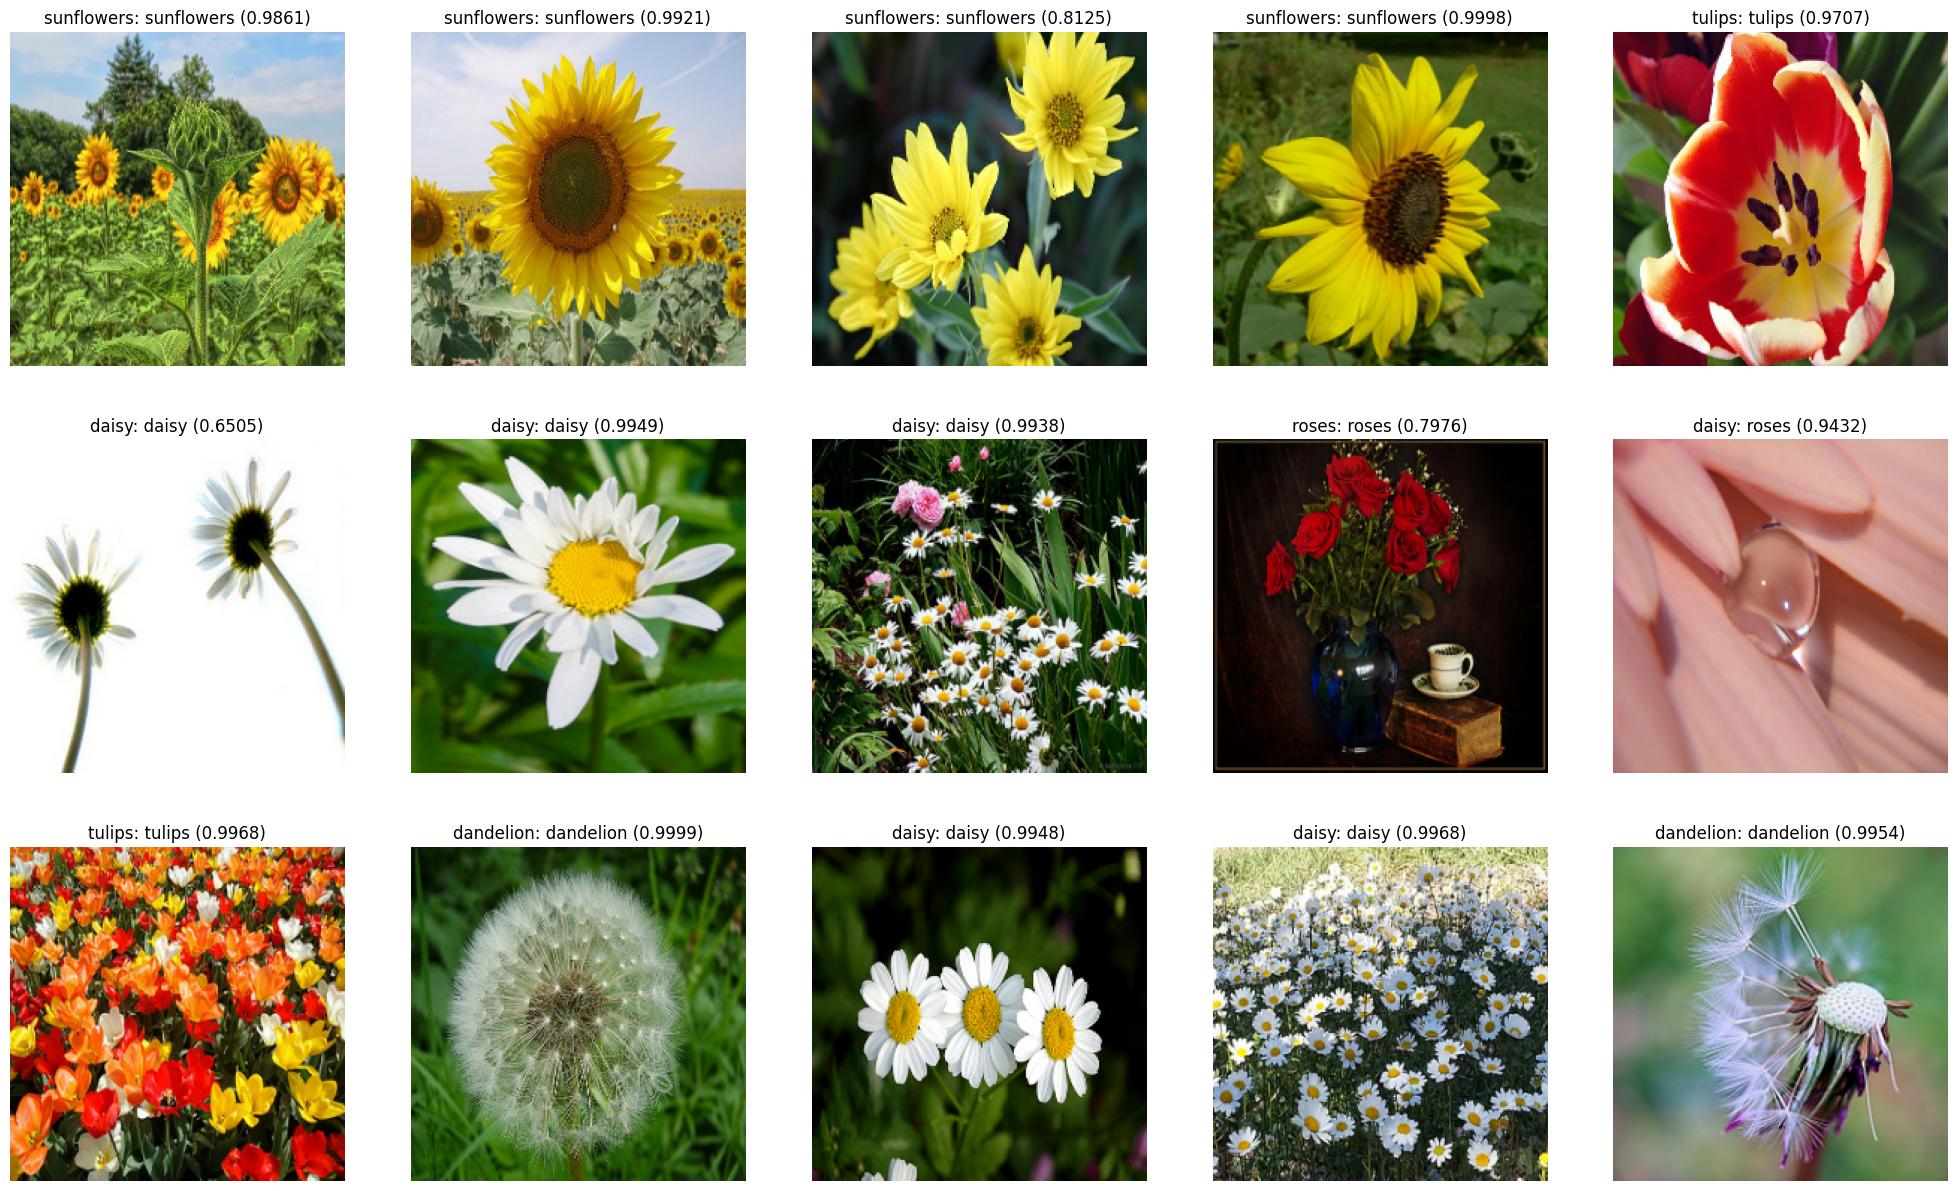

In [6]:
plot_predictions(model, "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")